# Aufgabe für die Projektgruppe 9

Bearbeiten Sie die folgende Aufgabe:

Ihr Auftraggeber ist eine Familie, welche eine Beratung von Ihnen benötigt. Sie besitzt ein kleines altes Windrad, welches nur für den Eigenverbrauch genutzt wird sowie eine PV Anlage. Die Familie möchte von Ihnen wissen, ob Sie Kosten durch die Investition in verschiedene Komponenten ihres Energiesystems einsparen kann. 

Nehmen Sie dabei die folgenden Angaben an:
* Nennleistung der Windernergieanlage: 5 kW (Keine EEG- Vergütung)
* Nennleistung der PV-Anlage 9 kWp (70% Kappungsgrenze berücksichtigen)
* Die Anschlussleistung an das elektrische Netz beträgt 15 kW
* Die Heizleistung des Erdgaskessel liegt bei 20 kW, der Wirkungsgrad ist 99%
* Erdgaspreis: 7 cent/kWh
* Strompreis: 30 cent/kWh
* EEG-Vergütung PV Anlage: 12,30 cent/kWh

Prüfen und kombinieren Sie mindestens drei der unten aufgeführten Optionen und bewerten Sie diese nach ihrer wirtschaftlicher Vorteilhaftigkeit. Unter den gewählten Optionen sollte sich mindestens eine der beiden Optionen BHKW oder Wärmepumpe befinden:
- Implementierung eines Heizstabes mit annuitätische Kosten von 50€ (Elektrische Leistung 5 kW, Wirkungsgrad 98%) 
- Installation eines BHKWs mit annuitätische Kosten von 1.200€ (Elektrische Leistung 1kW, elektrischer Wirkungsgrad 16%, Thermischer Wirkungsgrad 80%, nehmen Sie eine feste Stromkennzahl von 0,2 an, ein Beispiel für die Implementierung eines BHKWs in PyPSA finden Sie hier: https://pypsa.org/examples/chp-fixed-heat-power-ratio.html. Eine KWK-Vergütung müssen Sie nicht implementieren, da hier die pauschalierte Zuschlagzahlung gewählt wird.)
- Beschaffung einer elektrischen Batterie mit annuitätische Kosten von 900€ (8kWh Kapazität, 2,4 kW Speicher und Ladeleistung, einem Gesamtwirkungsgrad von 85%, keine Selbstentladungsverluste) 
- Erweiterung des Heizungssystems um einen thermischen Speicher mit annuitätische Kosten von 100€ (7kWh Kapazität und eine Ein und Ausspeicherleistung von 12 kW, keine Selbstentladungsverluste)
- Implementierung einer selbst gewählten Wärmepumpe. Hier müssen Sie nach geeigneten Daten zu Leistungen, Kosten und Performance recherchieren. Sie dürfen dabei die Jahresarbeitszahl als konstanten COP annehmen. Gehen Sie weiter davon aus, dass der Annuitätenfaktor für eine solche Investition bei 0,117 liegt.

1) Formulieren Sie die Optimierungsaufgabe
2) Skizzieren Sie das heutige System und bestimmen Sie die Kosten.
3) Skizzieren Sie mögliche Erweiterungen und bestimmen Sie die Kosten.
4) Interpretieren Sie die ihre Ergebnisse und ziehen Sie Schlussfolgerungen.
5) Bestimmen Sie die Grenzen Ihrer Modellierung und begründen Sie, ob die Ergebnisse trotz der Beschränkungen valide sind.

Der Import der Lastzeitreihen und der Einspeisezeitreihen ist unten schon vorbereitet. Diese repräsentieren das Jahr 2018 in stündlicher Auflösung. Nutzen Sie das in der Übung besprochene JupyterNotebook und schauen Sie sich die Funktionen und den Code dort an, um Ihr Energiesystem aufzubauen, es zu simulieren und auszuwerten.  

### Skizze
<img src="picture/Skizze_Wärmepumpe_und_Batterie.PNG">

# Import <a class="anchor" id="chapter1"></a>

## Import der benötigten Python Module <a class="anchor" id="section_1_1"></a>

In [1]:
import pypsa
import pandas as pd
import math
import numpy as np

## Import der Daten <a class="anchor" id="section_1_2"></a>

Die Werte der Zeitreihen sind in einem Unterordner "data" als csv-Datein abgelegt. Sie bilden das Jahr 2019 ab und werden mithilfe des Python Moduls pandas eingelesen und als Variablen angelegt. Dabei werden Parameter wie der Separator (hier ";") und die Indexspalte sowie die Funktion, aus der Indexspalte Zeit und Datenformate auszulesen gesetzt.

In [2]:
pv_infeed = pd.read_csv('./data/pv_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)
wind_infeed = pd.read_csv('./data/wind_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)

In [3]:
electrical_load = pd.read_csv('./data/SumProfiles_3600s.Electricity.csv', sep = ';', index_col='time', parse_dates=True)
thermal_load = pd.read_csv('./data/SumProfiles_3600s.Gas.csv', sep = ';', index_col='time', parse_dates=True)


Die eingelesenen Zeitreihen sind so noch nicht vollständig nutzbar. Um die Einspeisung der Wind und PV-Anlage zu normieren wird eine neue Spalte mit dem normierten Leistungsoutput sowie neue Spalten mit der Leistung der Last in den jeweiligen Variablen angelegt.

In [4]:
#Die gemessene PV-Einspeiseganglinie ist von einer Anlage mit einer Leistung von 9 kWp, die der Windenergieanlage mit 5 kW.
pv_infeed['p_max_pu'] = pv_infeed.electricity/9 
wind_infeed['p_max_pu'] = wind_infeed.electricity/5 

electrical_load['power_kw'] = electrical_load.sum_kwh #csv Datei
thermal_load['power_kw'] = thermal_load.sum_kwh #csv Datei vorher demand

Um einen kurzen Einblick in die Daten zu erhalten, schauen wir uns alle vier Tabellen an:

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

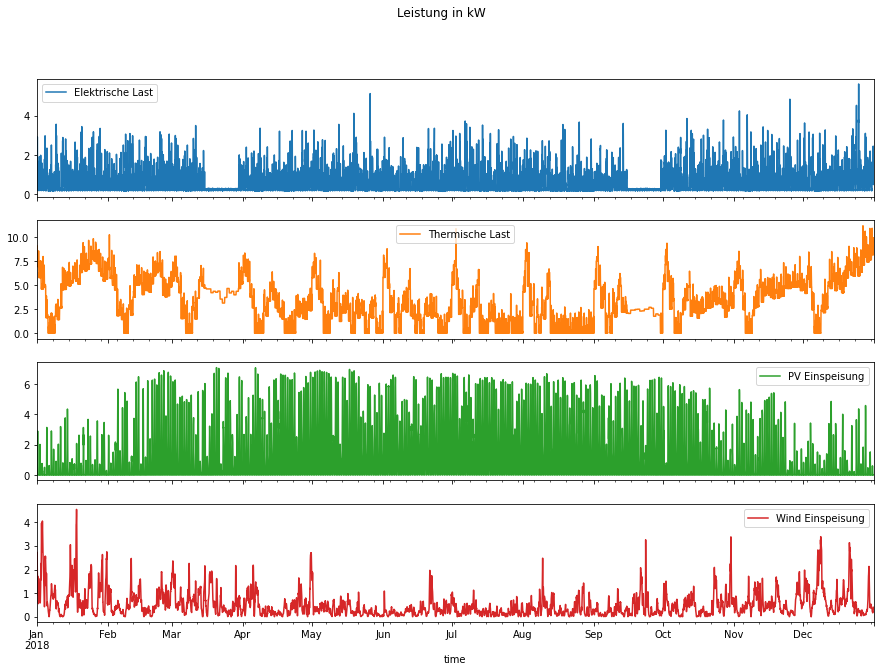

In [5]:
df_figure = pd.concat([electrical_load.sum_kwh, thermal_load.sum_kwh, pv_infeed.electricity,wind_infeed.electricity], axis = 1)
df_figure.columns = ['Elektrische Last', 'Thermische Last', 'PV Einspeisung', 'Wind Einspeisung']
df_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

# Definition der Variablen und Objekte <a class="anchor" id="chapter2"></a>

## Definition von Anlagenparametern <a class="anchor" id="section_2_1"></a>

Die Parameter der PV-Anlage und des Windrades werden hier definiert. Die Definition ist an reale technische Anlagen angelehnt. Um Einflüsse der verschiedenen Komponenten auf die Ergebnisse zu erfassen, können sie geändert werden.

### Komponenten des Haushalts <a class="anchor" id="section_2_1_1"></a>

In [6]:
# PV-Anlage
pv = {"electrical_power": 9.0}

# Wind-Anlage
wind = {"electrical_power": 5.0}

#Heizkessel
heating_boiler = {"thermal_power": 20.0,
                   "efficiency":0.99,# Effizienz als normierte Kennzahl
                   "gas_costs": 7} # Kosten in cent/kWh


### Netzanschluss <a class="anchor" id="section_2_1_2"></a>

Der Netzanschluss wird für den Haushalt mit 15 kW angenommen. 
Hier ist auch eine Kappungsgrenze bei 70% der Nennleistung der PV-Anlage implementiert.

In [7]:
# Leistungsbezug aus dem Netz
grid_import = {"electrical_power" : 15,
                "electricity_price": 30.0} #Preise in cent/kWh

# Leistungsabgabe in das Netz
grid_export = {"electrical_power" : 0.7 * pv["electrical_power"], #Repräsentiert die 70% Kappungsgrenze bei kleinen PV-Anlagen
                "electricity_revenue": 12.30} #EEG-Erlöse in cent/kWh

## Verwendung von PyPSA um das Energiemodell aufzubauen <a class="anchor" id="section_2_2"></a>

Im Folgenden verwenden wir das offene Python Modul PyPSA um unser Energiesystem zu bauen. Diese ist objektorientiert aufgebaut und hat verschiedene Module, welche zu einem Energiesystem zusammengesetzt werden können. Gleichzeitig kann der Einsatz der Komponenten nach Grenzkosten bestimmt werden. Es lassen sich auch AC- und DC-Netzflussberechnungen sowie Kapazitätsplanungen mit der Bibliothek ausführen.

### Definition des Netzwerks  <a class="anchor" id="section_2_2_1"></a>

Das Netzwerk ist das PyPSA Objekt, welches alle anderen Objekte enthält. Es definiert damit die Basisparameter unseres Energiesystems. Wir erstellen zunächst ein leeres Netzwerk und definieren dann die Zeitschritte. Diese lesen wir aus den Eingangsdaten ab.

In [8]:
#Netzwerk definieren
network = pypsa.Network()
network.set_snapshots(pv_infeed.index)
network.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 1 Stunde.

### Knoten definieren <a class="anchor" id="section_2_2_2"></a>

An Knoten werden bei PyPSA die Energieflüsse bilanziert und die Komponenten an diese angeschlossen. Wir definieren hier einen Strom- und einen thermischen Knoten.

In [9]:
#Stromknoten definieren
network.add("Bus", 
            name = "electricity_1")

network.add("Bus", 
            name = "electricity_2")

#Wärmeknoten definieren
network.add("Bus", 
            name = "thermal")

### Link definieren <a class="anchor" id="section_2_2_2"></a>

Link between two buses with controllable active power - can be used for a transport power flow model OR as a simplified version of point-to-point DC connection OR as a lossy energy converter. NB: for a lossless bi-directional HVDC or transport link, set p_min_pu = -1 and efficiency = 1. NB: It is assumed that the links neither produce nor consume reactive power.

In [10]:
#Link definieren
network.add("Link",
            name = "connection_e1_e2",
            bus0 = "electricity_1",
            bus1 = "electricity_2",
            p_nom = pv["electrical_power"])

### Lasten definieren <a class="anchor" id="section_2_2_3"></a>

An jeden Knoten wird nun eine Last angeschlossen. Diese wird mit den Leistungszeitreihen der jeweiligen Lasten belegt.

In [11]:
# Elektrische Last
network.add("Load", 
            name ="electricity_load", 
            bus = "electricity_2", 
            p_set = electrical_load.power_kw)

# Thermische last
network.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

### Erzeugungseinheiten definieren <a class="anchor" id="section_2_2_4"></a>

In PyPSA sind Erzeugungseinheiten als "Generator" definiert. Diese haben eine installierte Leistung "p_nom" und ggf. eine normierte maximale Leistung "p_max_pu".
Wir definieren die PV-Anlage und den Heizkessel.

In [12]:
#PV-Anlage
network.add("Generator", 
            name = "pv",
            bus = "electricity_1", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, #Anteil der maximal moeglichen Leistung
            marginal_cost = 0)
#Windanlage
network.add("Generator",
           name = "wind",
           bus = "electricity_2",
           p_nom = wind["electrical_power"],
           p_max_pu = wind_infeed.p_max_pu,
           marginal_cost = 0)
#Heizkessel
network.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

### Batterie hinzufuegen <a class="anchor" id="section_2_2_4"></a>

Batteriespeicher implementieren

In [13]:
# Batteriespeicher
#Hier können Sie die Aufgabe mit dem Batteriespeicher implementieren
# Hilfsknoten
network.add("Bus", 
            name = "storage_electricity")
#Einspeicherleistung vom Knoten "electricity_2" zum Knoten "storage_electricity"
network.add("Link", 
            name = "electrical_storage_charge", 
            bus0 = "electricity_2", 
            bus1 = "storage_electricity", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)
                    )
#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity_2"
network.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "storage_electricity", 
            bus1 = "electricity_2", 
            p_nom = 2.4,
            efficiency = math.sqrt(0.85)
                    )
#Speicher
network.add("Store", 
            name = "electricity_storage", 
            bus = "storage_electricity", 
            e_nom = 8,
            e_cyclic = True # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            )

### Waermepumpe definieren <a class="anchor" id="section_2_2_6"></a>

In [14]:
#Waermepumpe
network.add("Link",
            name = "Waermepumpe",
            bus0 = "electricity_2",
            bus1 = "thermal",
            p_nom = 1.32,
            efficiency = 4.1
            )

### Netzanschluss definieren <a class="anchor" id="section_2_2_6"></a>

Der Netzanschluss wird hier auch als "Generator" definiert. Das heißt es kann Leistung aus dem Netz für einen bestimmten Preis bezogen werden. Die Netzeinspeisung wird auch als "Generator" definiert, allerdings wird die Leistungsabgabe dieses Generators mit einem Vorzeichenwechsel umgedreht. Der "Generator" kann also Leistung aufnehmen. Zusätzlich sind die Kosten negativ um Erlöse durch die EEG-Vergütung abzubilden. 

In [15]:
#Netzbezug
network.add("Generator", 
            name = "grid_import",
            bus = "electricity_2", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung
network.add("Generator", 
            name = "grid_export",
            bus = "electricity_1", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

# Simulation <a class="anchor" id="chapter3"></a>

## Simulation der Basiskonfiguration inkl. Batterie<a class="anchor" id="section_3_1"></a>

Um die Basisvariante ohne Wärmepumpe zu berechnen, setzten wir die Leistung der Wärmepumpe temporär auf 0. 
Die in PyPSA implementierte Funktion lopf optimiert den Einsatz aller Komponenten so, dass die dabei entstehenden Kosten minimal sind.

In [16]:
# Simulation der Basiskonfiguration für den kompletten Zeitraum:
network.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.53s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.29e+04


('ok', 'optimal')

## Auswertungsfunktion <a class="anchor" id="section_3_2"></a>

Funktionen werden in python üblicherweise am Anfang eines Scriptes definiert. Aus didaktischen Gründen kommt die Definition der Funktion erst jetzt. Für Aufgaben, welche wir mehrfach ausführen, lohnt sich die Definition einer Funktion. Diese kann dann im weiteren Verlauf immer wieder aufgerufen werden. 
Wir werten hier das gelöste Netzwerk nach den gewünschten Parametern aus. 

In [17]:
#Auswertung der Kosten und Anteile
def cost_share_evaluation(network):
    '''
    This function evaluate the solved PyPSA network to get the costs, revenues and the share of the selfconsumption.
    
    Parameters
    ----------
    network:            PyPSA Network
                        The solved PyPSA network with all corresponding devices
    Returns
    -------
    results :           dict
                        The dictionary with all the results.
    '''
    
    grid_import = (network.generators_t.p['grid_import'] * network.snapshot_weightings).sum()
    grid_export = (network.generators_t.p['grid_export'] * network.snapshot_weightings).sum() #grid_export betrachtet kompletten Knoten 1
    self_consumed_pv = (network.generators_t.p['pv'] * network.snapshot_weightings).sum()- grid_export
    self_consumed_wind = (network.generators_t.p['wind'] * network.snapshot_weightings).sum()#ohne grid_export
    self_consumption_ratio = (self_consumed_pv + self_consumed_wind)/(grid_export + self_consumed_pv + self_consumed_wind)
    Autarkiegrad = (self_consumed_pv + self_consumed_wind)/(grid_import + self_consumed_pv + self_consumed_wind)
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import']
    electricty_revenues = grid_export * network.generators.marginal_cost['grid_export']
    gas_costs = (network.generators_t.p['boiler']*network.snapshot_weightings).sum() * network.generators.marginal_cost['boiler']
    
    curtailment_pv = ((network.generators_t.p_max_pu['pv']*network.generators.p_nom['pv'] - network.generators_t.p['pv'])*network.snapshot_weightings).sum()
    curtailment_wind = ((network.generators_t.p_max_pu['wind']*network.generators.p_nom['wind'] - network.generators_t.p['wind'])*network.snapshot_weightings).sum()
#reminder: Wortsuche
    
    results = {"Eigenverbrauchsanteil": self_consumption_ratio,
               "Autarkie": Autarkiegrad,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricty_revenues,
              "Gesamtkosten": electricity_cost + gas_costs + electricty_revenues + 90000 + 972070 * 0.117, #jaehrliche Kosten Batterie und Heizstab in ct
              "Nicht nutzbare Energie pv": curtailment_pv,     #getrennt betrachten
              "Nicht nutzbare Energie wind": curtailment_wind}
    results_energy = {'Abregelung': curtailment_pv + curtailment_wind,
                      'Netzeinspeisung': grid_export,
                      'Eigenverbrauch': self_consumed_pv + self_consumed_wind,
                      'Netzbezug': -grid_import}
                      
    return results, results_energy



Erklärung curtailment : https://pypsa.readthedocs.io/en/latest/components.html#generator

Ausführung der Auswertungsfunktion:

In [18]:
results_base, results_energy_base  = cost_share_evaluation(network)

#Die Werte sollen auch als Text ausgegeben werden
print("Der Eigenverbrauchsanteil am Stromverbrauch in der Konfiguration mit Batterie und Wärmepumpe beträgt "
      + str(round(results_base["Eigenverbrauchsanteil"]*100,2))
      + "%, während der Autarkiegrad bei "
      + str(round(results_base["Autarkie"]*100,2))
      +"% liegt. Dabei entstehen Stromkosten von "
      +str(round(results_base["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_base["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_base["Stromerlöse"]/100,2))
      +"€, wobei " +str(round(results_base["Nicht nutzbare Energie pv"]/100,1))+ "kWh PV-Strom abgeregelt werden muessen."
      + str(round(results_base["Nicht nutzbare Energie wind"]/100,1))+ "kWh Wind-Strom werden abgeregelt."
      +" Die Gesamtkosten betragen "+ str(round(results_base["Gesamtkosten"]/100,2)) +"€."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der Konfiguration mit Batterie und Wärmepumpe beträgt 56.89%, während der Autarkiegrad bei 96.33% liegt. Dabei entstehen Stromkosten von 99.55€, Gaskosten von 841.52€ und EEG-Erlöse von 812.38€, wobei 0.0kWh PV-Strom abgeregelt werden muessen.2.2kWh Wind-Strom werden abgeregelt. Die Gesamtkosten betragen 2166.02€.


## Visualisierung der Ergebnisse der elektrischen Last <a class="anchor" id="section_3_3"></a>

<AxesSubplot:xlabel='time'>

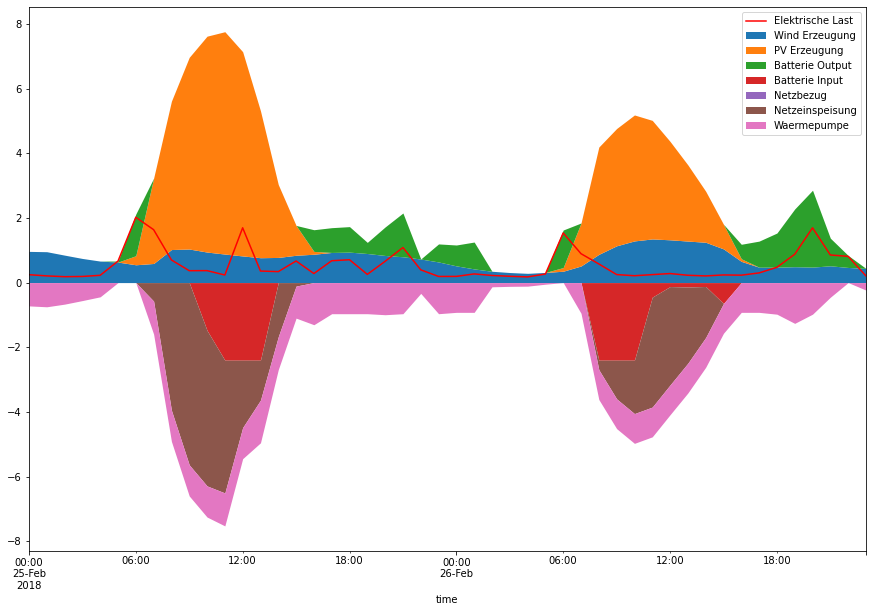

In [19]:
load_figure = network.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'

ax = load_figure.loc['02-25-18 00:00:00':'02-26-18 23:00:00'].plot(legend = True, color = 'red')
df_figure_base = pd.concat([network.generators_t.p['wind'],network.generators_t.p['pv'], network.links_t.p0['electricity_storage_discharge'],-network.links_t.p0['electrical_storage_charge'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export'], -network.links_t.p0['Waermepumpe']], axis = 1)
df_figure_base.columns = ['Wind Erzeugung','PV Erzeugung','Batterie Output','Batterie Input','Netzbezug', 'Netzeinspeisung', 'Waermepumpe']
df_figure_base.loc['02-25-18 00:00:00':'02-26-18 23:00:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)

## Visualisierung der Ergebnisse der thermischen Last <a class="anchor" id="section_3_3"></a>

<AxesSubplot:xlabel='time'>

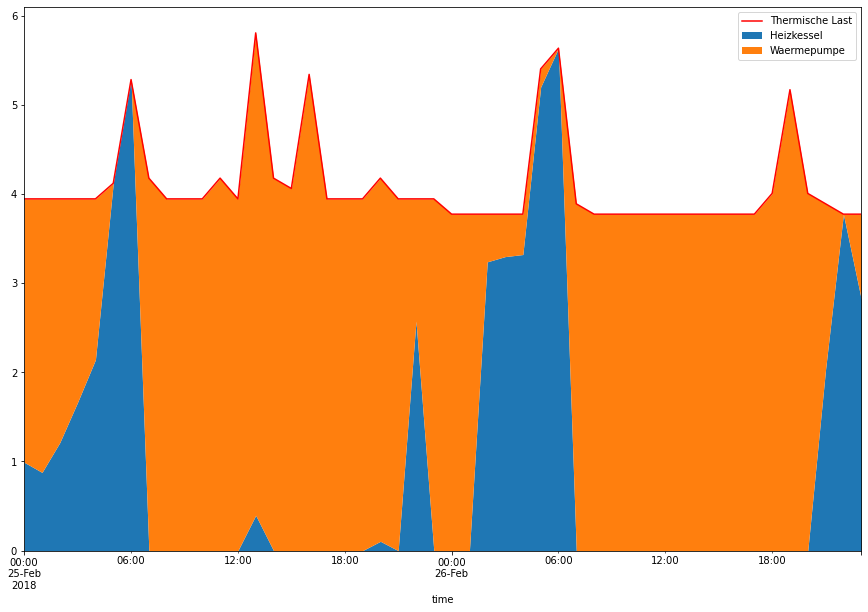

In [20]:
load_figure = network.loads_t.p_set['thermal_load']
load_figure.name = 'Thermische Last'
ax = load_figure.loc['02-25-18 00:00:00':'02-26-18 23:00:00'].plot(legend = True, color = 'red')
df_figure_base = pd.concat([network.generators_t.p['boiler'], network.links_t.p0['Waermepumpe']*pd.Series(data = 4.1, index = network.snapshots)], axis = 1)
df_figure_base.columns = ['Heizkessel','Waermepumpe']
df_figure_base.loc['02-25-18 00:00:00':'02-26-18 23:00:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax)